In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

d:\software\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

path = './datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d:\software\miniconda3\envs\py39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


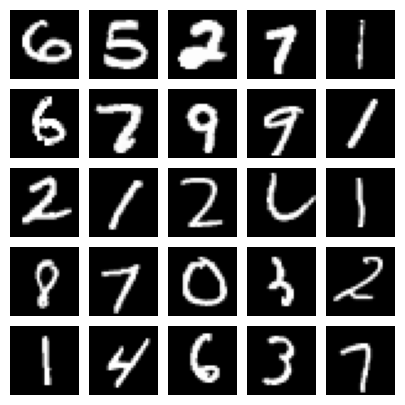

In [3]:
dataiter = iter(train_loader)
image = dataiter.next()

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [27]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, latent_dim),
                nn.LeakyReLU(0.2),
                )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(
                nn.Linear(2, latent_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(latent_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, input_dim),
                nn.Sigmoid(),
                )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [28]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)

In [29]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + KLD

In [43]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _)  in enumerate(train_loader):
            x = x.view(x.shape[0], x.shape[-1]*x.shape[-2]).to(device)

            optimizer.zero_grad()
            x_hat, mean, logvar = model(x)
            loss = loss_function(x, x_hat, mean, logvar)
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()
            
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [46]:
train(model, optimizer, epochs=10, device=device)


	Epoch 1 	Average Loss:  141.81081762069311
	Epoch 2 	Average Loss:  141.14814102955353
	Epoch 3 	Average Loss:  140.60843495426016
	Epoch 4 	Average Loss:  140.13649907886472
	Epoch 5 	Average Loss:  139.64006291902982
	Epoch 6 	Average Loss:  139.14633866660614
	Epoch 7 	Average Loss:  138.87171446971405
	Epoch 8 	Average Loss:  138.51725775563818
	Epoch 9 	Average Loss:  138.20531882587662
	Epoch 10 	Average Loss:  137.77907234583145


8253517.5498046875